# Bayesian Workflow: Homework solutions

In [1]:
import load_covid_data
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import warnings
warnings.simplefilter("ignore")

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

sampler_kwargs = {"chains": 4, "cores": 4, "return_inferencedata": True}

## Load data

First we'll load data on COVID-19 cases from the WHO. In order to ease analysis we will remove any days were confirmed cases was below 100 (as reporting is often very noisy in this time-frame). It also allows us to align countries with each other for easier comparison.

In [2]:
df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]
df.head()

country  state       type  confirmed  critical_estimate  \
date                                                                      
2020-03-27  Afghanistan    NaN  confirmed        110                5.5   
2020-03-28  Afghanistan    NaN  confirmed        110                5.5   
2020-03-29  Afghanistan    NaN  confirmed        120                6.0   
2020-03-30  Afghanistan    NaN  confirmed        170                8.5   
2020-03-31  Afghanistan    NaN  confirmed        174                8.7   

            days_since_100  deaths  
date                                
2020-03-27             0.0       4  
2020-03-28             1.0       4  
2020-03-29             2.0       4  
2020-03-30             3.0       4  
2020-03-31             4.0       4

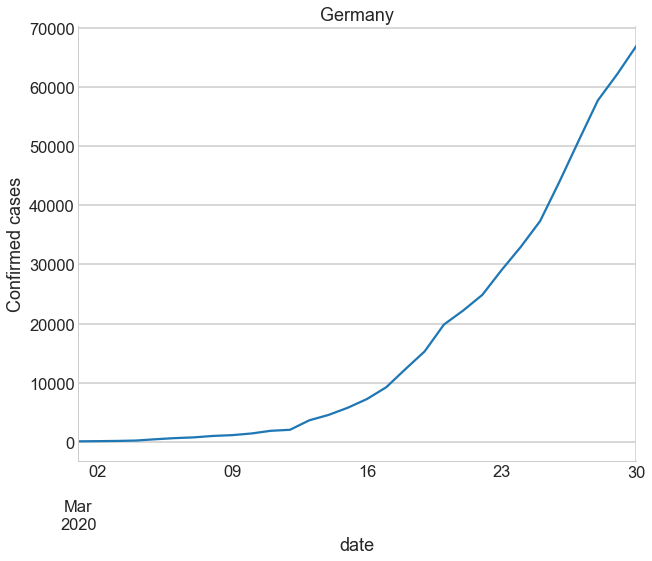

In [3]:
country = 'Germany'
df_country = df.loc[lambda x: (x.country == country)].iloc[:30]

fig, ax = plt.subplots(figsize=(10, 8))
df_country.confirmed.plot(ax=ax)
ax.set(ylabel='Confirmed cases', title=country)
sns.despine()

Let's take `model_exp2` and make it hierarchical for these countries:

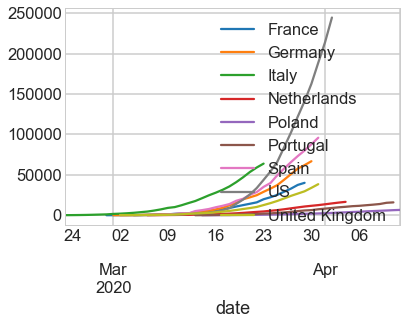

In [4]:
countries = ["Germany", "US", "United Kingdom", "France", "Poland",
             "Italy", "Portugal", "Netherlands", "Spain"]
n_countries = len(countries)
df_countries = df.loc[df.country.isin(countries)].loc[lambda x: x.days_since_100 < 30]
df_countries.groupby("country").confirmed.plot(legend=True);

Here is a basic implementation:

In [6]:
with pm.Model() as model_hierarchical:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 120, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', mu=0.1, sigma=1)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .1)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_countries)
    
    alpha = pm.Gamma("alpha", mu=6, sigma=1)
    
    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df_countries.loc[lambda x: (x.country == country)]
        
        growth = a_ind[i] * (1 + b_ind[i]) ** df_country.days_since_100.values

        # Due to the exponential, growth can easily take on values
        # too large for our likelihood which causes problems
        # during prior predictive sampling, so we put a maximum on here
        growth = tt.clip(growth, 0, 10_000_000)
        
        # Likelihood
        pm.NegativeBinomial(
            country_name,
            growth,
            alpha=alpha,
            observed=df_country.confirmed.values)

### Prior predictive check

Run a prior predictive check and plot the results together with the data. Is this a good model? Can you improve it?

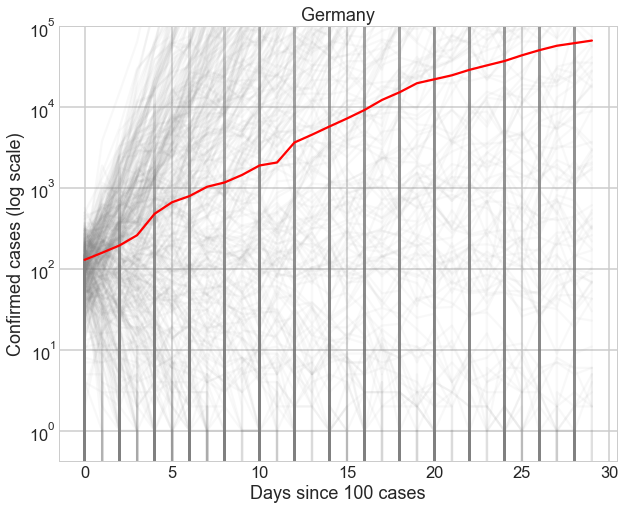

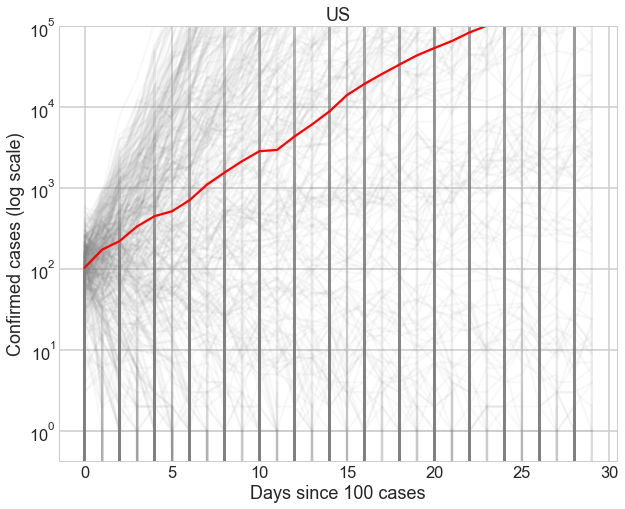

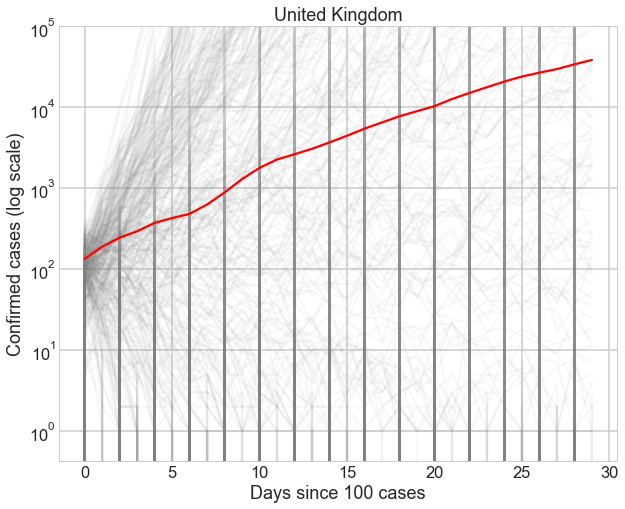

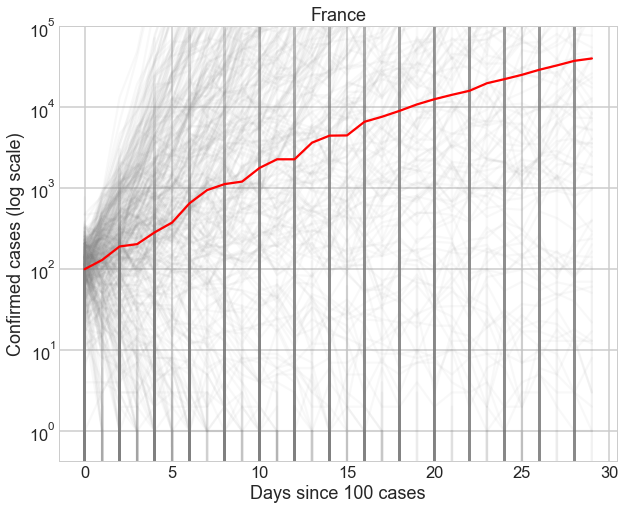

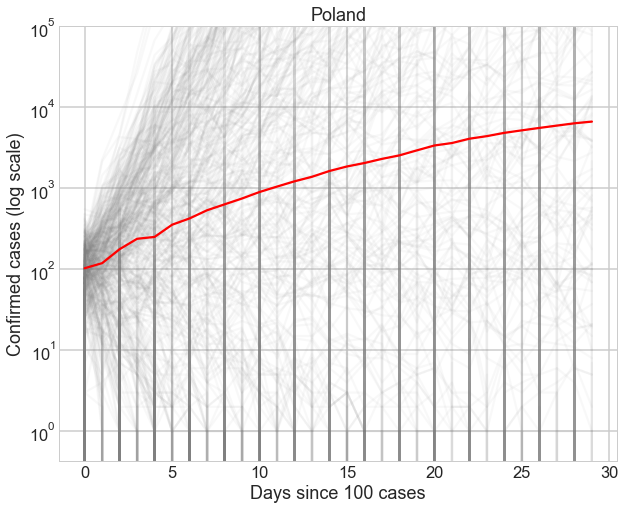

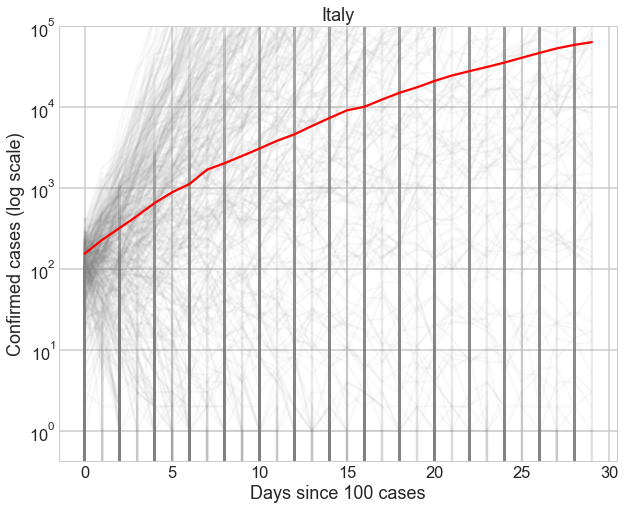

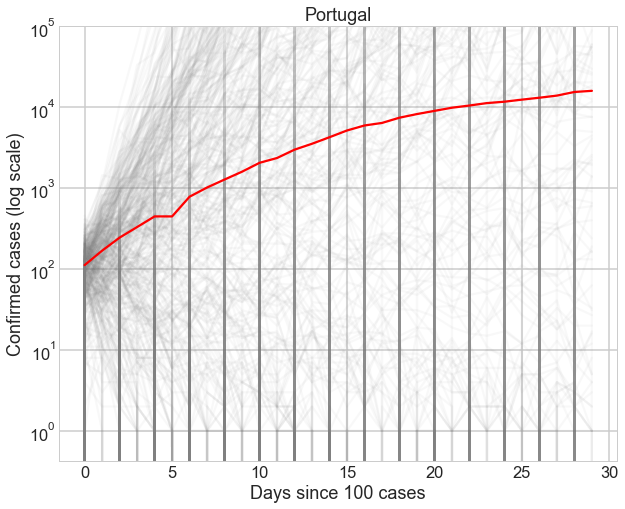

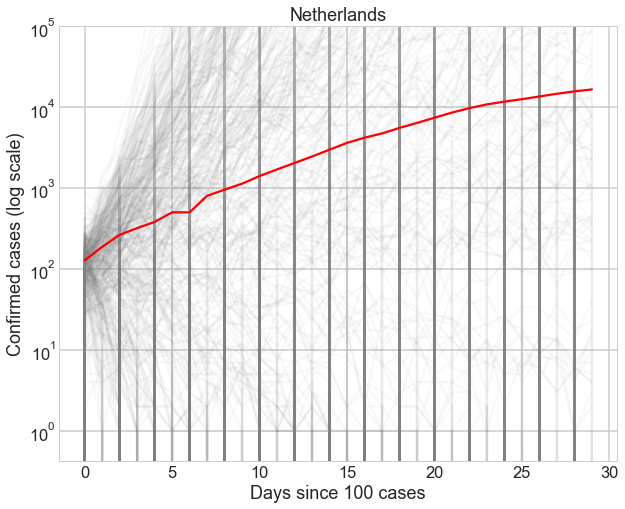

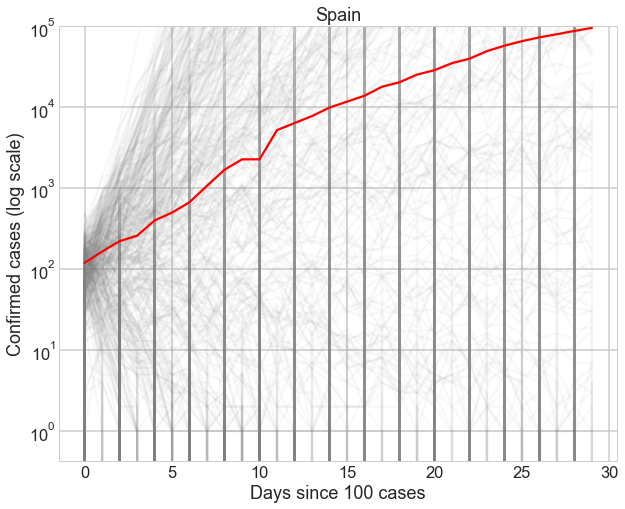

In [7]:
with model_hierarchical:
    prior_pred = pm.sample_prior_predictive()

for country in countries:
    df_country = df_countries.loc[lambda x: (x.country == country)]
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(prior_pred[country].T, color='0.5', alpha=.05)
    ax.plot(df_country.confirmed.values, color='r', label='data')
    ax.set(xlabel="Days since 100 cases", 
           ylabel="Confirmed cases (log scale)",
           ylim=(-100_000, 100_000), title=country, 
           yscale="log");

Improved model:

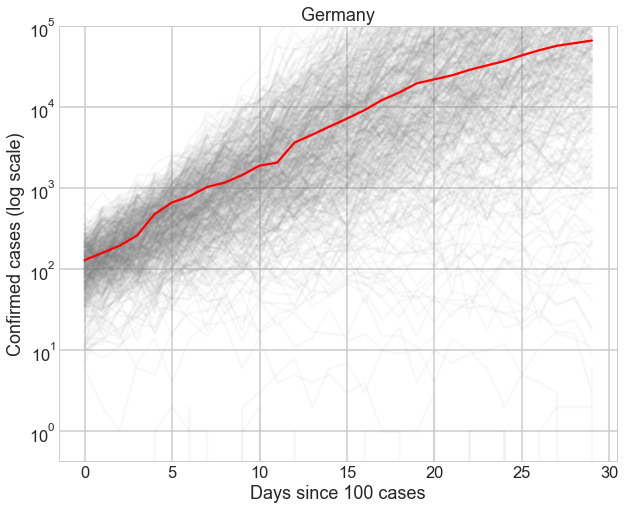

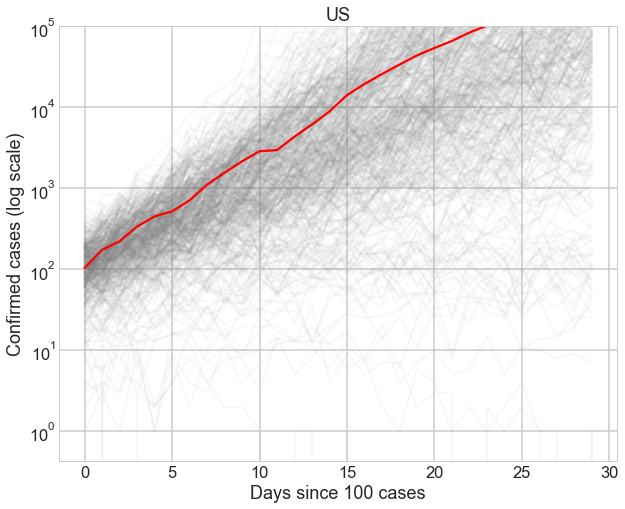

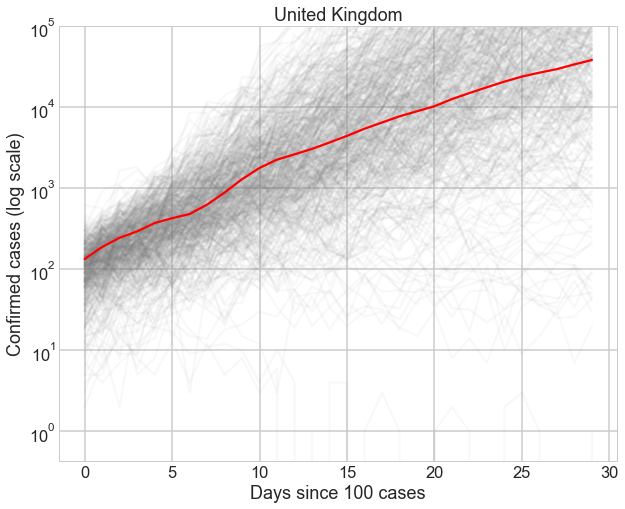

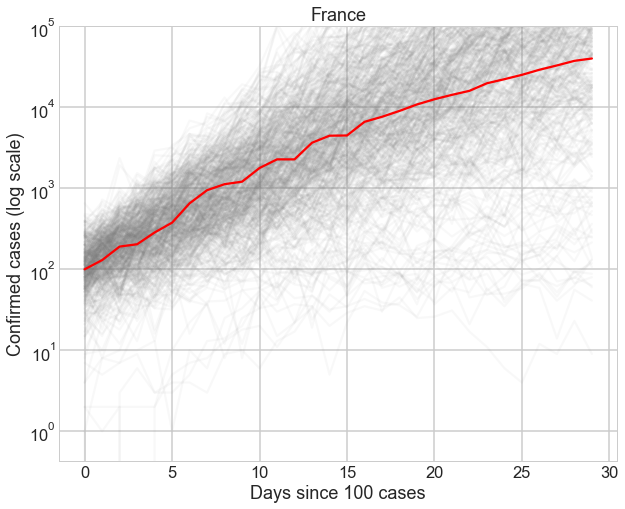

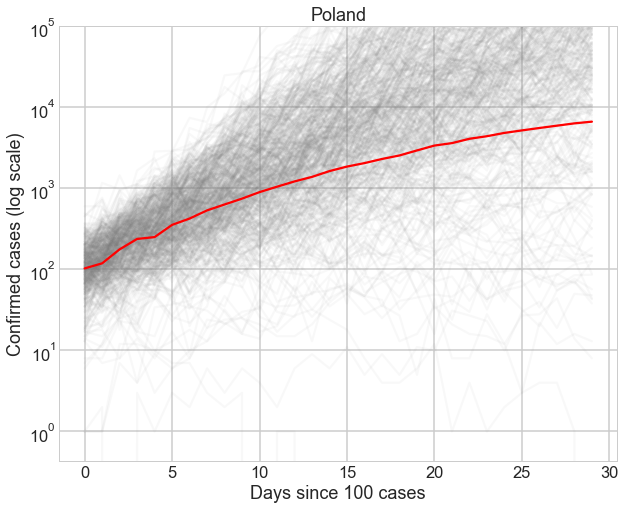

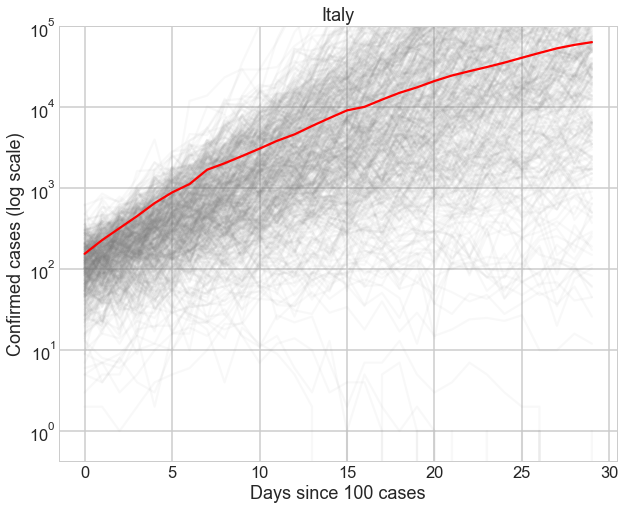

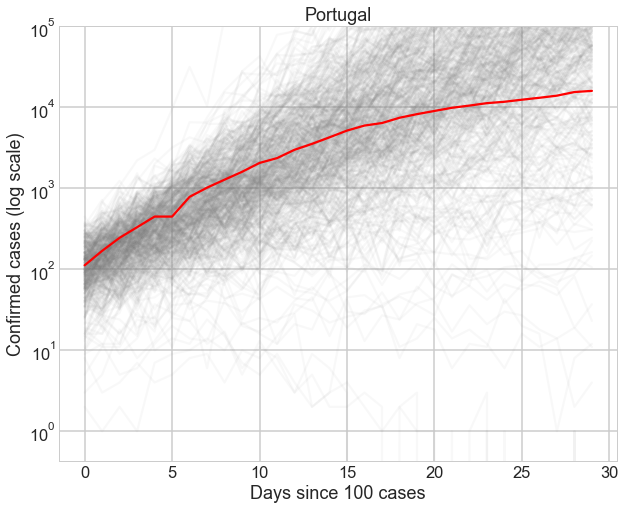

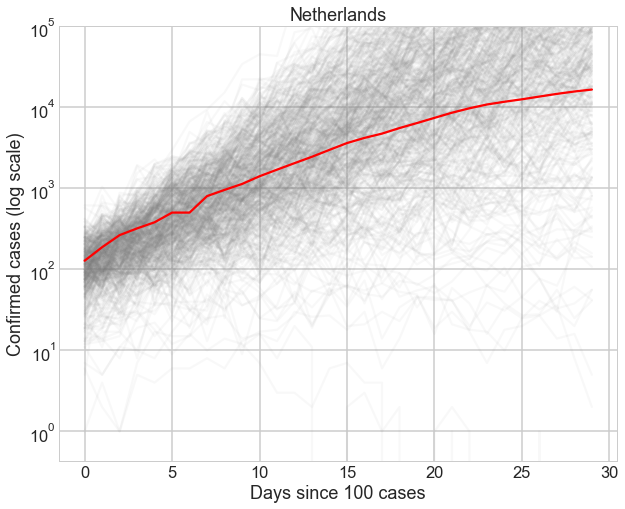

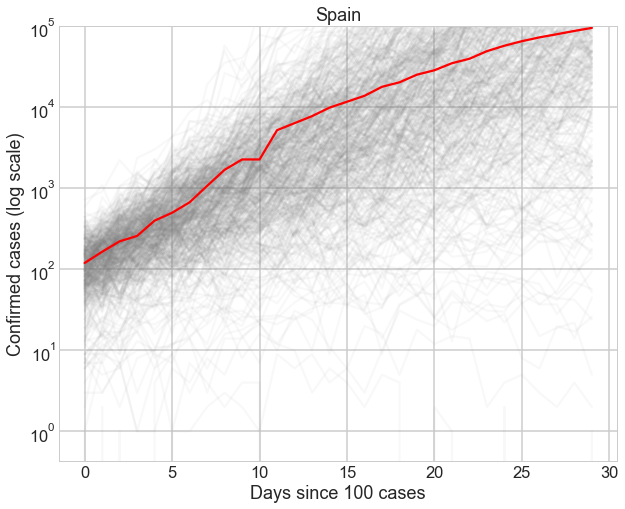

In [8]:
with pm.Model() as model_hierarchical:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 120, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_countries)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', mu=0.3, sigma=.1)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .1)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_countries)
    
    alpha = pm.Gamma("alpha", mu=6, sigma=1)
    
    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df_countries.loc[lambda x: (x.country == country)]
        
        growth = a_ind[i] * (1 + b_ind[i]) ** df_country.days_since_100.values

        # Due to the exponential, growth can easily take on values
        # too large for our likelihood which causes problems
        # during prior predictive sampling, so we put a maximum on here
        growth = tt.clip(growth, 0, 10_000_000)
        
        # Likelihood
        pm.NegativeBinomial(
            country_name,
            growth,
            alpha=alpha,
            observed=df_country.confirmed.values)
        

    prior_pred = pm.sample_prior_predictive()

for country in countries:
    df_country = df_countries.loc[lambda x: (x.country == country)]
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(prior_pred[country].T, color='0.5', alpha=.05)
    ax.plot(df_country.confirmed.values, color='r', label='data')
    ax.set(xlabel="Days since 100 cases", 
           ylabel="Confirmed cases (log scale)",
           ylim=(0, 100_000), title=country, 
           yscale="log");

## Sample from the posterior and assess convergence

Perform sampling and see if there are any problems.

What have you learned about hierarchical models that might help with any potential problems? Change the model to be non-centered. This blog post might help: https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/

In [9]:
with model_hierarchical:
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 401 seconds.
There were 549 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.32932269206661274, but should be close to 0.8. Try to increase the number of tuning steps.
There were 495 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3245934131256496, but should be close to 0.8. Try to increase the number of tuning steps.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4635527811682952, but should be close to 0.8. Try to increase the number of tuning steps.
There were 322 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6011342820424538, but should be clos

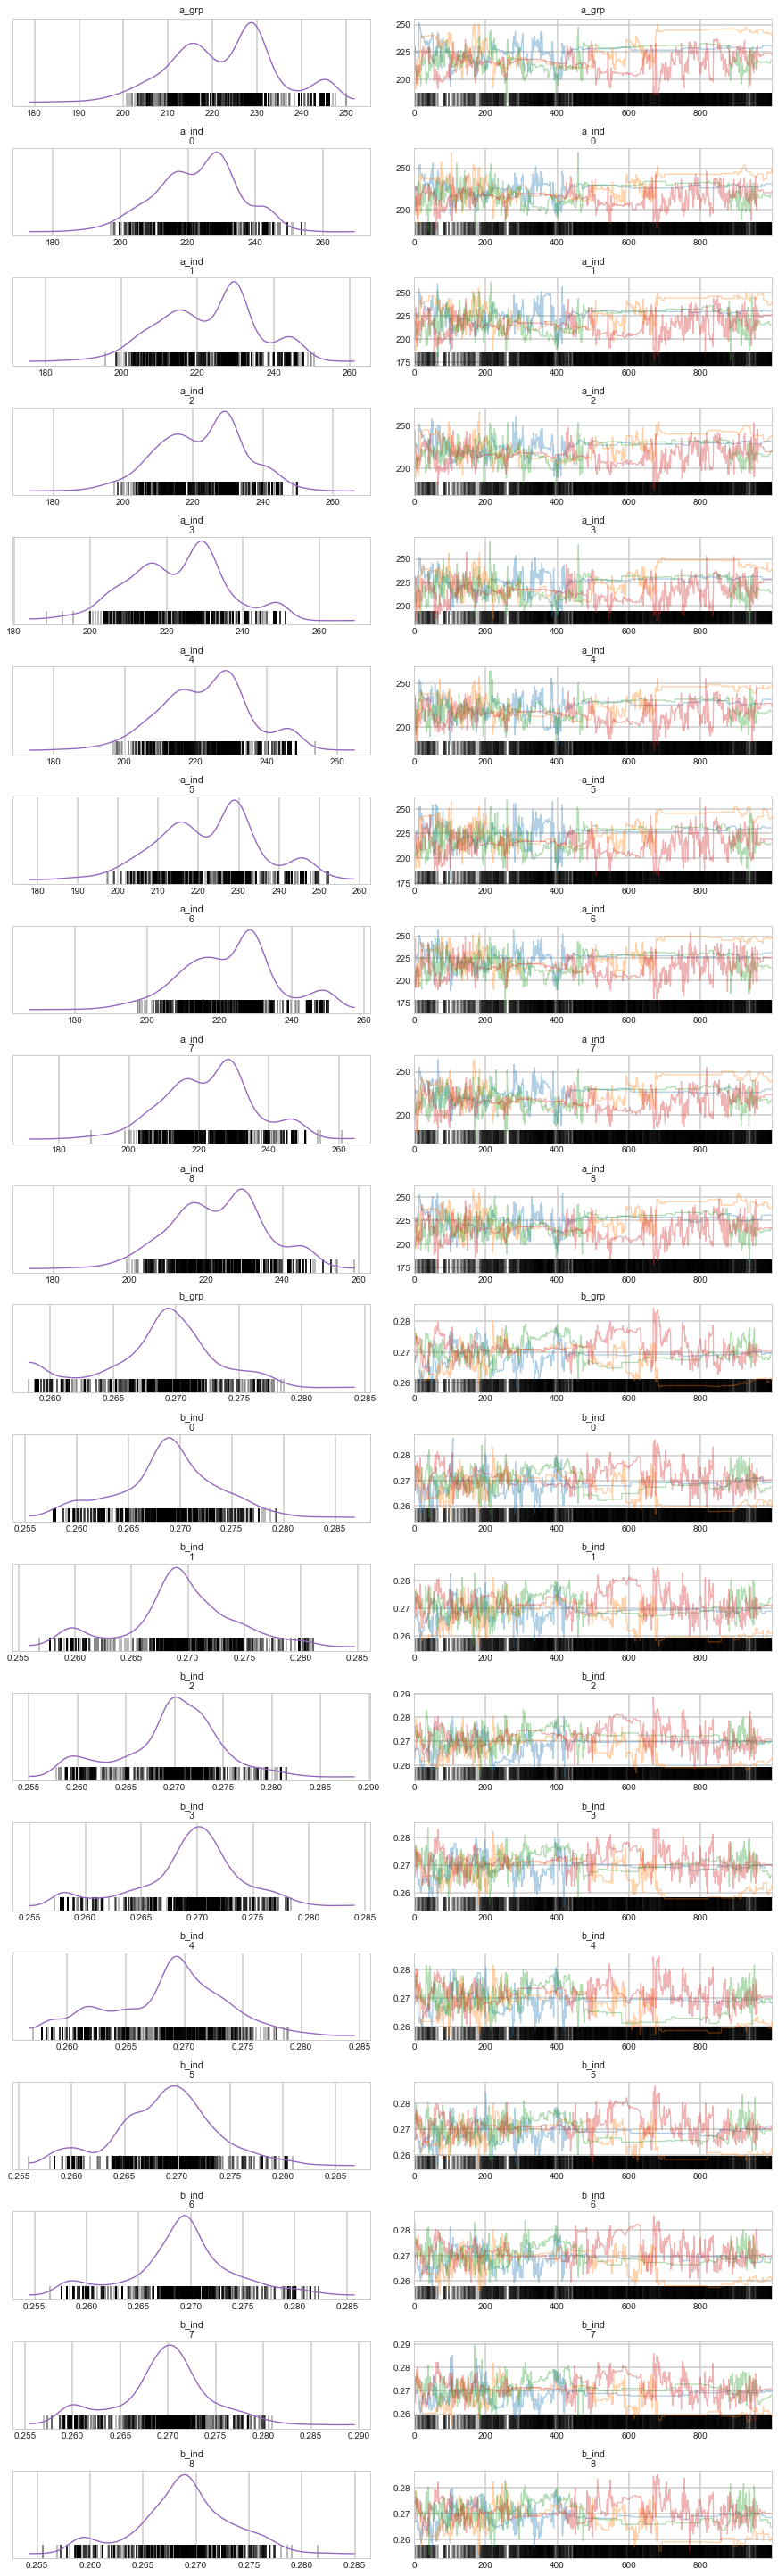

In [10]:
az.plot_trace(trace, combined=True);

In [11]:
with pm.Model() as model_hierarchical_non_centered:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 120, 50)
    # Group sd
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind_raw = pm.Normal('a_ind', shape=n_countries)
    
    a_ind = a_ind_raw * a_grp_sigma + a_grp
    
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', mu=0.33, sigma=.1)
    # Group sd
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .1)
    # Individual slopes
    b_ind_raw = pm.Normal('b_ind', shape=n_countries)
    
    b_ind = b_ind_raw * b_grp_sigma + b_grp
    
    alpha = pm.Gamma("alpha", mu=6, sigma=1)
    
    # Create likelihood for each country
    for i, country_name in enumerate(countries):
        df_country = df_countries.loc[lambda x: (x.country == country)]
        
        growth = a_ind[i] * (1 + b_ind[i]) ** df_country.days_since_100.values
        
        # Due to the exponential, growth can easily take on values
        # too large for our likelihood which causes problems
        # during prior predictive sampling, so we put a maximum on here
        growth = tt.clip(growth, 0, 10_000_000)
        
        # Likelihood
        pm.NegativeBinomial(
            country_name,
            growth,
            alpha=alpha,
            observed=df_country.confirmed.values)
        
    trace_non_centered = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 997 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


## 5. Assess convergence

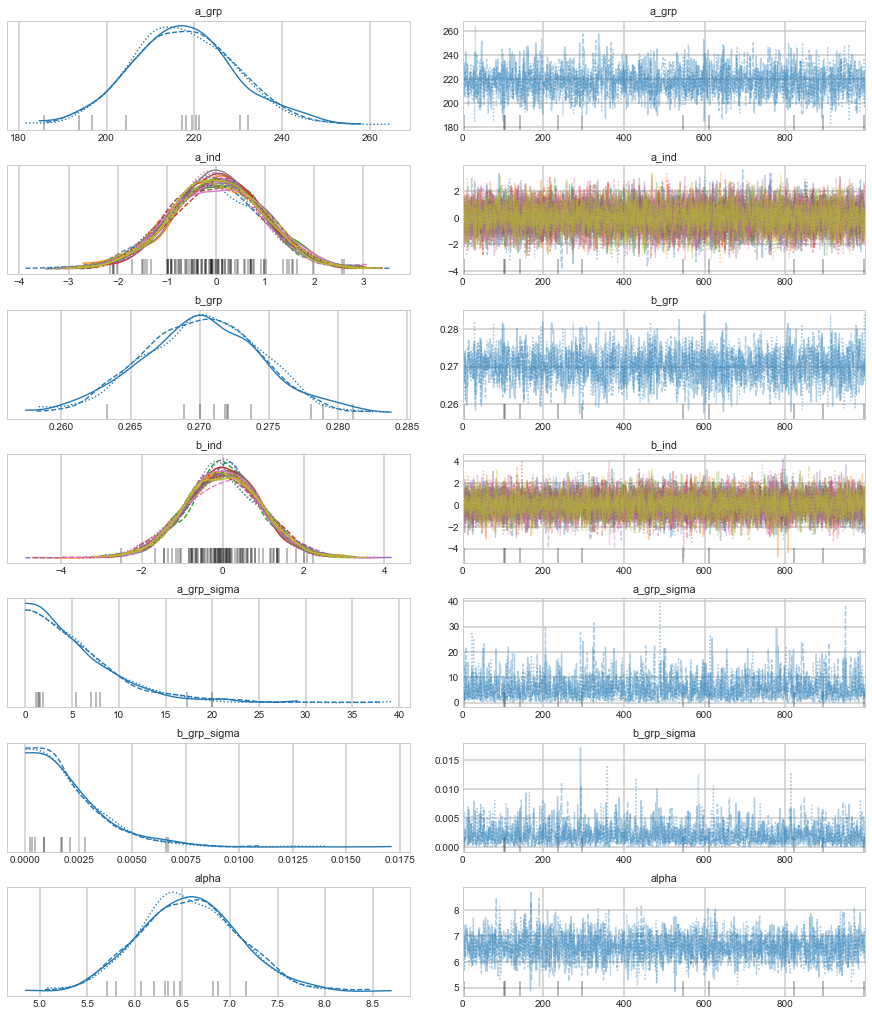

In [16]:
az.plot_trace(trace_non_centered, compact=True);

In [17]:
az.summary(trace_non_centered)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a_grp        217.639  11.666  195.663  239.515      0.254    0.180    2110.0   
a_ind[0]      -0.003   0.990   -1.785    1.950      0.018    0.021    2915.0   
a_ind[1]       0.022   0.929   -1.636    1.909      0.017    0.017    2846.0   
a_ind[2]       0.033   0.929   -1.631    1.872      0.018    0.019    2551.0   
a_ind[3]       0.035   0.938   -1.643    1.893      0.017    0.017    3058.0   
a_ind[4]       0.016   0.913   -1.618    1.778      0.017    0.017    3031.0   
a_ind[5]       0.023   0.939   -1.655    1.819      0.017    0.018    2948.0   
a_ind[6]       0.026   0.958   -1.702    1.918      0.018    0.018    2940.0   
a_ind[7]       0.015   0.944   -1.897    1.737      0.018    0.021    2633.0   
a_ind[8]       0.037   0.950   -1.896    1.675      0.018    0.018    2876.0   
b_grp          0.270   0.004    0.262    0.278      0.000    0.000    1820.0   
b_ind[0]       0.009   0.915   -1.685    1.788      0.018    0.018    2717.0   
b_ind[1]       0.026   0.940   -1.784    1.703      0.020    0.018    2230.0   
b_ind[2]       0.001   0.942   -1.767    1.769      0.017    0.019    3183.0   
b_ind[3]       0.012   0.928   -1.724    1.753      0.017    0.019    3056.0   
b_ind[4]       0.023   0.950   -1.643    1.925      0.019    0.019    2421.0   
b_ind[5]       0.023   0.950   -1.777    1.847      0.018    0.019    2733.0   
b_ind[6]       0.001   0.966   -1.854    1.791      0.017    0.019    3133.0   
b_ind[7]      -0.002   0.917   -1.849    1.620      0.017    0.017    2954.0   
b_ind[8]       0.026   0.948   -1.711    1.826      0.018    0.019    2809.0   
a_grp_sigma    5.543   4.811    0.008   14.153      0.109    0.083    1960.0   
b_grp_sigma    0.002   0.002    0.000    0.005      0.000    0.000    2075.0   
alpha          6.574   0.511    5.613    7.481      0.010    0.007    2741.0   

             ess_sd  ess_bulk  ess_tail  r_hat  
a_grp        2100.0    2121.0    1825.0    1.0  
a_ind[0]     1132.0    2881.0    1931.0    1.0  
a_ind[1]     1458.0    2847.0    2009.0    1.0  
a_ind[2]     1174.0    2540.0    1671.0    1.0  
a_ind[3]     1470.0    3056.0    2365.0    1.0  
a_ind[4]     1496.0    3019.0    2056.0    1.0  
a_ind[5]     1363.0    2951.0    2020.0    1.0  
a_ind[6]     1388.0    2952.0    1771.0    1.0  
a_ind[7]     1026.0    2620.0    1432.0    1.0  
a_ind[8]     1334.0    2882.0    1817.0    1.0  
b_grp        1817.0    1832.0    1648.0    1.0  
b_ind[0]     1291.0    2722.0    2090.0    1.0  
b_ind[1]     1387.0    2258.0    1728.0    1.0  
b_ind[2]     1212.0    3186.0    2006.0    1.0  
b_ind[3]     1240.0    3053.0    1918.0    1.0  
b_ind[4]     1281.0    2440.0    1775.0    1.0  
b_ind[5]     1285.0    2725.0    2033.0    1.0  
b_ind[6]     1360.0    3131.0    1957.0    1.0  
b_ind[7]     1460.0    2948.0    2121.0    1.0  
b_ind[8]     1311.0    2798.0    1855.0    1.0  
a_grp_sigma  1680.0    1746.0    1406.0    1.0  
b_grp_sigma  2012.0    1983.0    1791.0    1.0  
alpha        2737.0    2705.0    1723.0    1.0

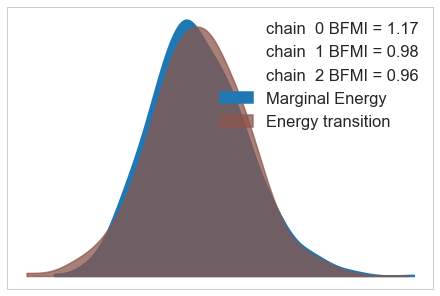

In [14]:
az.plot_energy(trace_non_centered);

### Run posterior predictive check

Run a posterior predictive check and plot the results together with the data. Is this a good model?

In [21]:
with model_hierarchical_non_centered:
    # Draw sampels from posterior predictive
    post_pred_non_centered = pm.sample_posterior_predictive(
        trace_non_centered.posterior,
        samples=100)

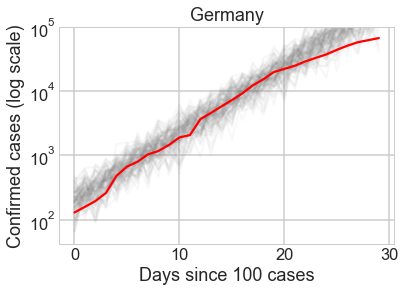

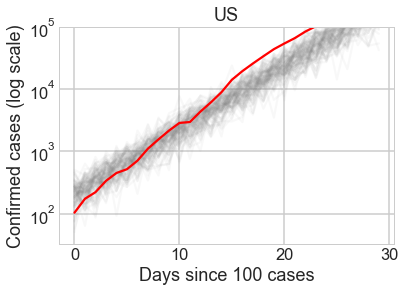

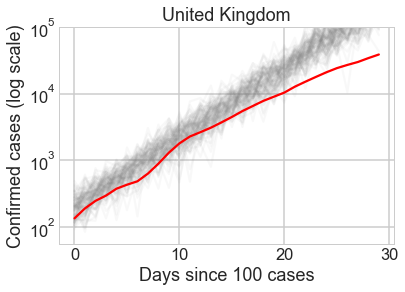

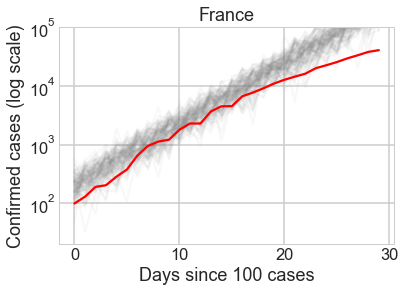

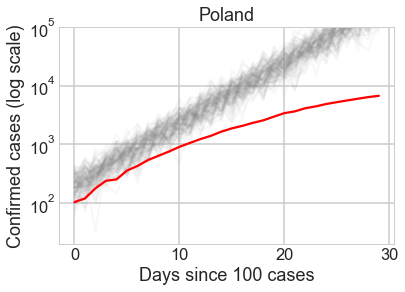

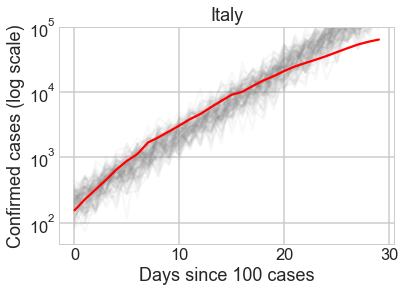

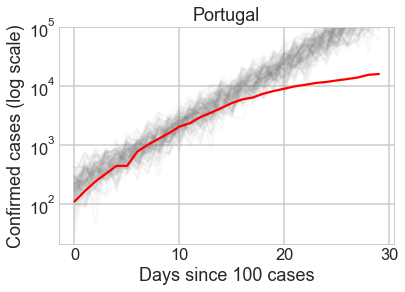

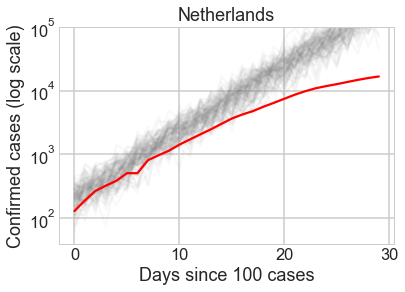

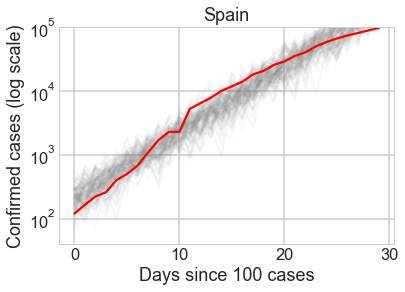

In [22]:
for country in countries:
    df_country = df_countries.loc[lambda x: (x.country == country)]
    fig, ax = plt.subplots()
    ax.plot(post_pred_non_centered[country].T, color='0.5', alpha=.05)
    ax.plot(df_country.confirmed.values, color='r', label='data')
    ax.set(xlabel="Days since 100 cases", 
           ylabel="Confirmed cases (log scale)",
           ylim=(0, 100_000), title=country, 
           yscale="log");

### Model comparison

Build a fully pooled model and do model comparison with the hierarchical model.

In [20]:
t = df_countries.days_since_100.values
confirmed = df_countries.confirmed.values

with pm.Model() as model_pooled:
    # Intercept
    a = pm.Normal('a', mu=125, sigma=25)

    # Slope
    b = pm.Normal('b', mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood
    pm.NegativeBinomial('obs',
                 growth,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=confirmed)
    
    trace_pooled = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, b, a]


ValueError: Not enough samples to build a trace.

In [ ]:
az.plot_trace(trace_pooled);

In [ ]:
with model_pooled:
    post_pred_pooled = pm.sample_posterior_predictive(trace_pooled.posterior)

### Run a posterior predictive check and plot the results

In [ ]:
obs = np.reshape(post_pred_pooled["obs"], (500, -1, 30))

for i, country in enumerate(countries):
    df_country = df_countries.loc[lambda x: (x.country == country)]
    fig, ax = plt.subplots()
    ax.plot(obs[i, :].T, color='0.5', alpha=.05)
    ax.plot(df_country.confirmed.values, color='r', label='data')
    ax.set(xlabel="Days since 100 cases", 
           ylabel="Confirmed cases (log scale)",
           ylim=(0, 100_000), title=country, 
           yscale="log");

## Define a summary statistic and compare the models based on that

In [ ]:
obs = np.reshape(post_pred["obs"], (500, -1, 30))

mse_pooled = {}
mse_hierarchical = {}

for i, country in enumerate(countries):
    df_country = df_countries.loc[lambda x: (x.country == country)]
    mse_pooled[country] = np.mean((np.log(df_country.confirmed.values[:, np.newaxis]) - np.log(obs[i, :].T))**2)
    mse_hierarchical[country] = np.mean((np.log(df_country.confirmed.values[:, np.newaxis]) - np.log(post_pred_non_centered[country].T))**2)

In [ ]:
pd.Series(mse_pooled).mean()

In [ ]:
pd.Series(mse_hierarchical).mean()

Which model seems to do better based on your own defined summary statistic? Does the result surprise you? Think of why that could be the case. Hint: Look at the trace of sigma_grp.